In [119]:
from google.colab import drive
drive.mount("/gdrive")


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [120]:
# Set seed for reproducibility
SEED = 42

import os
import random
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

import numpy as np
np.random.seed(SEED)
random.seed(SEED)

import torch
torch.manual_seed(SEED)
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms

logs_dir = "tensorboard"
os.makedirs("models", exist_ok=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline


PyTorch version: 2.9.0+cu126
Device: cuda


In [121]:
current_dir = "/gdrive/My Drive/[2025-2026] AN2DL/Challenge 2/dataset"
train_data_dir = f"{current_dir}/train_data"
test_data_dir = f"{current_dir}/test_data"
csv_path = f"{current_dir}/train_labels.csv"

import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import RandAugment

# Carico le etichette

df = pd.read_csv(csv_path)
if "sample_index" not in df.columns:
    df.columns = ["sample_index", "label"]

# Filtra sample senza maschera
all_files = set(os.listdir(train_data_dir))
valid_imgs = {
    f for f in all_files
    if f.startswith("img_") and f.replace("img_", "mask_") in all_files
}

SAMPLES_TO_IGNORE = [
    "img_0102.png", "img_0104.png", "img_0108.png", "img_0109.png", "img_0112.png",
    "img_0130.png", "img_0147.png", "img_0152.png", "img_0153.png", "img_0168.png",
    "img_0173.png", "img_0176.png", "img_0182.png", "img_0189.png", "img_0193.png",
    "img_0203.png", "img_0213.png", "img_0218.png", "img_0223.png", "img_0228.png",
    "img_0232.png", "img_0237.png", "img_0239.png", "img_0249.png", "img_0250.png",
    "img_0256.png", "img_0264.png", "img_0269.png", "img_0270.png", "img_0271.png",
    "img_0276.png", "img_0277.png", "img_0282.png", "img_0290.png", "img_0291.png",
    "img_0304.png", "img_0308.png", "img_0318.png", "img_0322.png", "img_0323.png",
    "img_0328.png", "img_0336.png", "img_0342.png", "img_0348.png", "img_0357.png",
    "img_0365.png", "img_0368.png", "img_0369.png", "img_0370.png", "img_0379.png",
    "img_0384.png", "img_0386.png", "img_0390.png", "img_0391.png", "img_0394.png",
    "img_0404.png", "img_0406.png", "img_0411.png", "img_0413.png", "img_0418.png",
    "img_0422.png", "img_0426.png", "img_0428.png", "img_0430.png", "img_0436.png",
    "img_0438.png", "img_0442.png", "img_0446.png", "img_0447.png", "img_0448.png",
    "img_0451.png", "img_0454.png", "img_0455.png", "img_0456.png", "img_0469.png",
    "img_0471.png", "img_0478.png", "img_0480.png", "img_0481.png", "img_0487.png",
    "img_0489.png", "img_0492.png", "img_0493.png", "img_0495.png", "img_0503.png",
    "img_0505.png", "img_0509.png", "img_0511.png", "img_0512.png", "img_0514.png",
    "img_0516.png", "img_0518.png", "img_0520.png", "img_0521.png", "img_0526.png",
    "img_0527.png", "img_0529.png", "img_0536.png", "img_0554.png", "img_0555.png",
    "img_0559.png", "img_0572.png", "img_0574.png", "img_0586.png", "img_0589.png",
    "img_0592.png", "img_0594.png", "img_0597.png", "img_0600.png", "img_0606.png",
    "img_0608.png", "img_0612.png", "img_0629.png", "img_0631.png", "img_0648.png",
    "img_0650.png", "img_0652.png", "img_0653.png", "img_0655.png", "img_0665.png",
    "img_0673.png", "img_0681.png", "img_0687.png", "img_0703.png", "img_0714.png",
    "img_0731.png", "img_0733.png", "img_0735.png", "img_0748.png", "img_0753.png",
    "img_0755.png", "img_0758.png", "img_0767.png", "img_0771.png", "img_0796.png",
    "img_0800.png", "img_0804.png", "img_0813.png", "img_0817.png", "img_0819.png",
    "img_0822.png", "img_0825.png", "img_0826.png", "img_0829.png", "img_0832.png",
    "img_0846.png", "img_0866.png", "img_0868.png", "img_0892.png", "img_0893.png",
    "img_0898.png", "img_0903.png", "img_0906.png", "img_0907.png", "img_0910.png",
    "img_0913.png", "img_0918.png", "img_0919.png", "img_0924.png", "img_0930.png",
    "img_0935.png", "img_0936.png", "img_0937.png", "img_0941.png", "img_0944.png",
    "img_0958.png", "img_0960.png", "img_0963.png", "img_0973.png", "img_0982.png",
    "img_0991.png", "img_0992.png", "img_0999.png", "img_1004.png", "img_1005.png",
    "img_1006.png", "img_1009.png", "img_1011.png", "img_1015.png", "img_1017.png",
    "img_1021.png", "img_1023.png", "img_1035.png", "img_1037.png", "img_1039.png",
    "img_1041.png", "img_1046.png", "img_1062.png", "img_1086.png", "img_1108.png",
    "img_1109.png", "img_1114.png", "img_1124.png", "img_1125.png", "img_1133.png",
    "img_1145.png", "img_1146.png", "img_1150.png", "img_1156.png", "img_1177.png",
    "img_1184.png", "img_1186.png", "img_1202.png", "img_1206.png", "img_1212.png",
    "img_1217.png", "img_1218.png", "img_1220.png", "img_1223.png", "img_1229.png",
    "img_1232.png", "img_1236.png", "img_1241.png", "img_1245.png", "img_1258.png",
    "img_1261.png", "img_1263.png", "img_1267.png", "img_1271.png", "img_1274.png",
    "img_1277.png", "img_1280.png", "img_1281.png", "img_1298.png", "img_1300.png",
    "img_1312.png", "img_1317.png", "img_1320.png", "img_1326.png", "img_1327.png",
    "img_1329.png", "img_1332.png", "img_1334.png", "img_1335.png", "img_1338.png",
    "img_1340.png", "img_1360.png", "img_1361.png", "img_1362.png", "img_1367.png",
    "img_1369.png", "img_1375.png", "img_1376.png", "img_1377.png", "img_1381.png",
    "img_1385.png", "img_1388.png", "img_1389.png", "img_1392.png", "img_1192.png",
]

df = df[df["sample_index"].isin(valid_imgs)]
df = df[~df["sample_index"].isin(SAMPLES_TO_IGNORE)].reset_index(drop=True)
print("Sample validi dopo img+mask filter:", len(df))

# Label mapping
class_names = sorted(df["label"].unique())
label_to_index = {name: idx for idx, name in enumerate(class_names)}
df["label_index"] = df["label"].map(label_to_index)
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

# Train/validation split (stratified)
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=SEED
)
print(f"Train samples: {len(train_df)}, Val samples: {len(val_df)}")

INPUT_SIZE = 128

class MaskedCropDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, padding=10):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.padding = padding

    def _get_bbox_from_mask(self, mask):
        ys, xs = np.where(mask > 0)
        if len(xs) == 0 or len(ys) == 0:
            return None
        x1, x2 = xs.min(), xs.max()
        y1, y2 = ys.min(), ys.max()
        return x1, y1, x2, y2

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row["sample_index"]

        img_path  = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.img_dir, img_name.replace("img_", "mask_"))

        image = np.array(Image.open(img_path).convert("RGB"))
        mask  = np.array(Image.open(mask_path).convert("L"))

        bbox = self._get_bbox_from_mask(mask)
        if bbox is not None:
            x1, y1, x2, y2 = bbox
            h, w = image.shape[:2]
            x1 = max(0, x1 - self.padding)
            y1 = max(0, y1 - self.padding)
            x2 = min(w, x2 + self.padding)
            y2 = min(h, y2 + self.padding)
            image = image[y1:y2, x1:x2]

        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        label = row["label_index"]
        return image, label

    def __len__(self):
        return len(self.df)


##//////ADVICE 3 sulla tempesta, rendo l'augmentation totalmente randomica//////////////
train_transform_tl = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])


train_transform_ft = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    RandAugment(num_ops=2, magnitude=7),
    transforms.RandomRotation(15),
    transforms.ColorJitter(
        brightness=0.1,
        contrast=0.1,
        saturation=0.1,
        hue=0.05
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

val_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

train_dataset = MaskedCropDataset(train_df, train_data_dir, transform=train_transform_tl)
val_dataset   = MaskedCropDataset(val_df,   train_data_dir, transform=val_transform)

def make_loader(ds, batch_size, shuffle, drop_last=False):
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,
    )

BATCH_SIZE = 32
train_loader = make_loader(train_dataset, BATCH_SIZE, shuffle=True,  drop_last=False)
val_loader   = make_loader(val_dataset,   BATCH_SIZE, shuffle=False, drop_last=False)

# Alias per le fasi di training/fine-tuning
train_tl_loader, val_tl_loader = train_loader, val_loader
train_ft_loader, val_ft_loader = train_loader, val_loader

data_transforms = val_transform


Sample validi dopo img+mask filter: 1162
Number of classes: 4
Train samples: 929, Val samples: 233


In [122]:
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
print(f"Input tensor shape: (3, {INPUT_SIZE}, {INPUT_SIZE})")


Train samples: 929, Val samples: 233
Input tensor shape: (3, 128, 128)


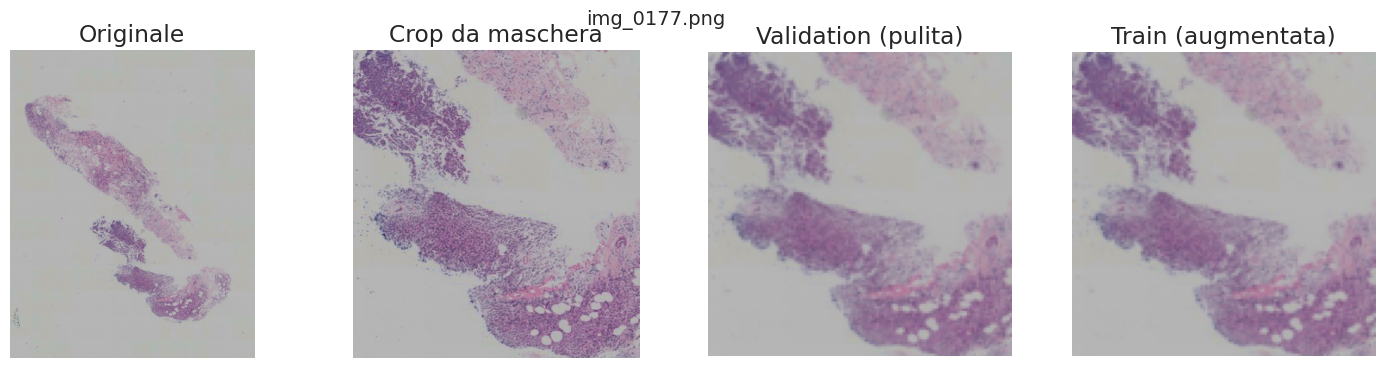

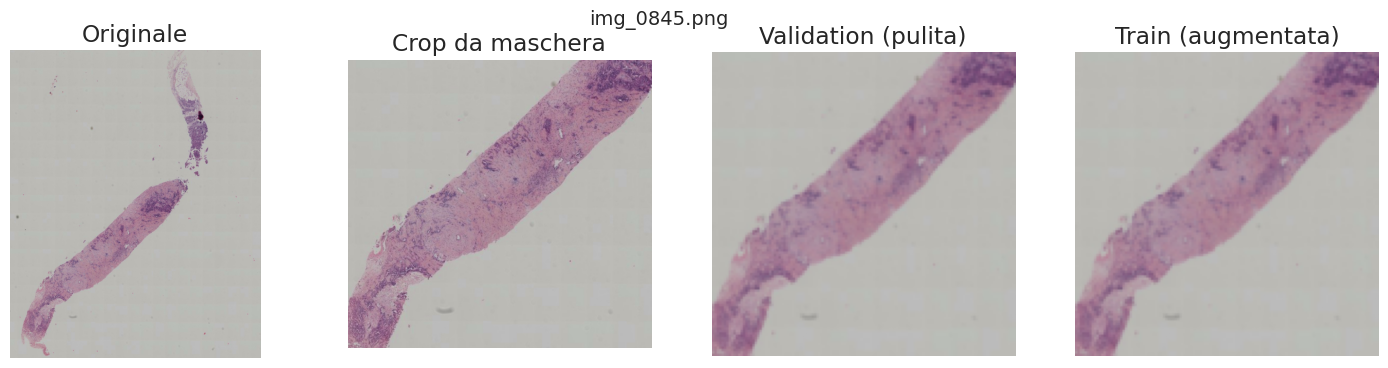

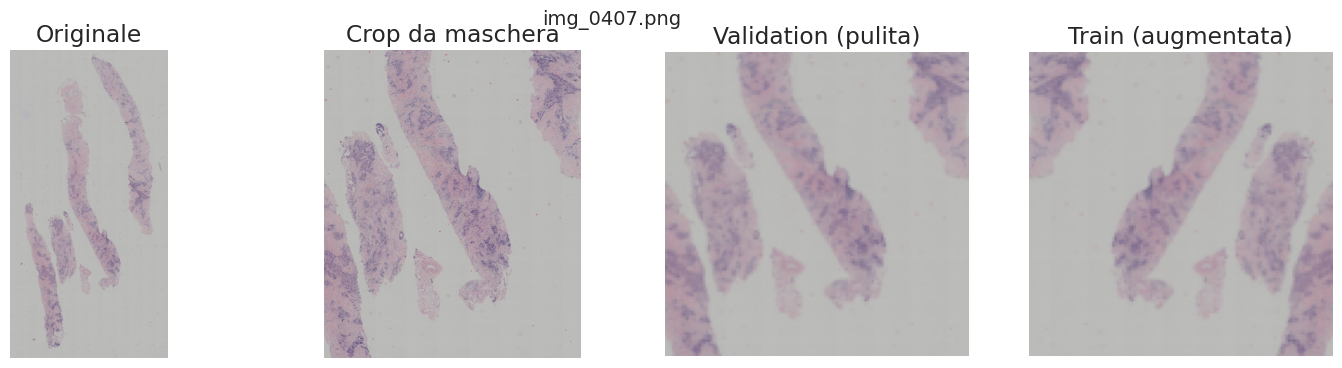

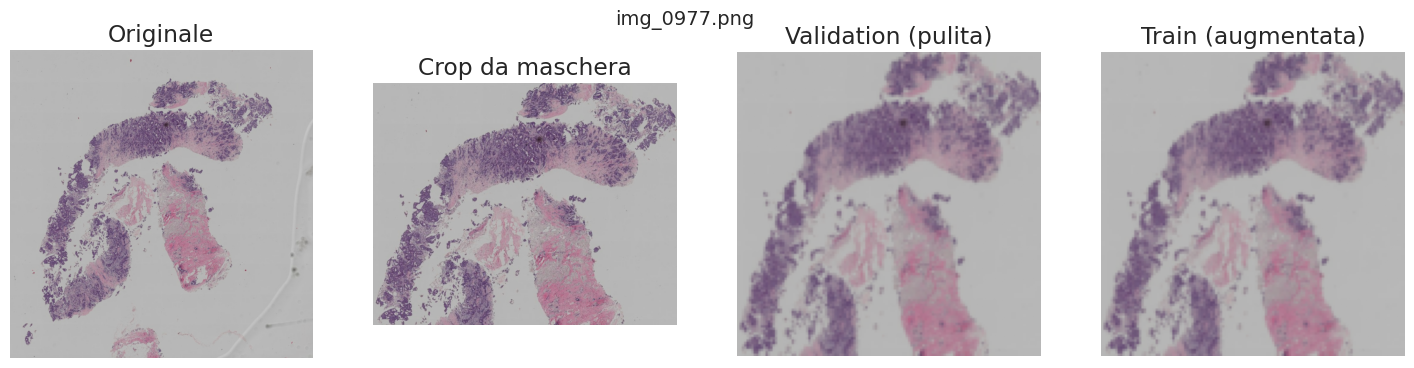

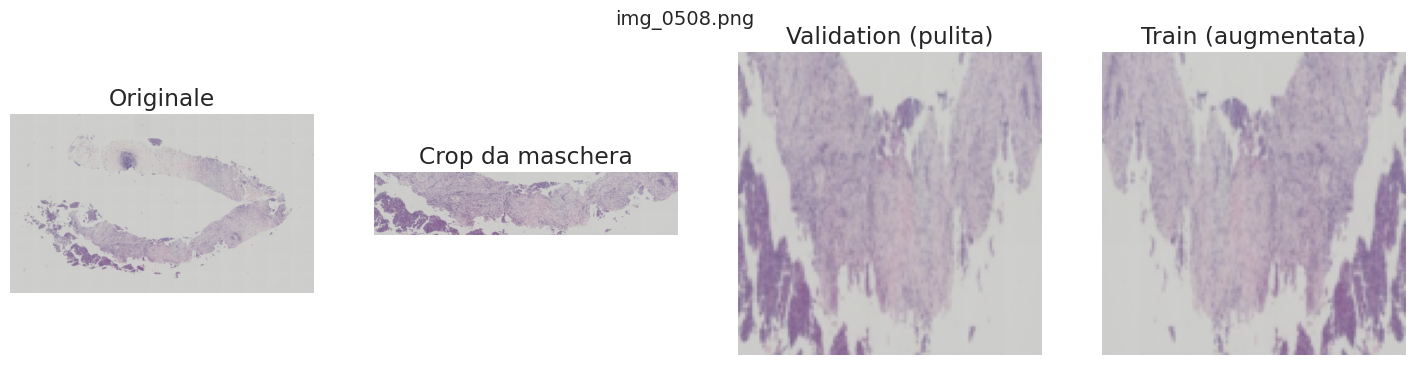

In [123]:
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def unnormalize(img, mean, std):
    img = img.copy()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    return np.clip(img, 0, 1)

def show_mask_and_augment_effect(dataset, train_transform, val_transform, n=3):
    indices = random.sample(range(len(dataset)), n)

    for idx in indices:
        row = dataset.df.iloc[idx]
        img_name = row["sample_index"]
        img_path  = os.path.join(dataset.img_dir, img_name)
        mask_path = os.path.join(dataset.img_dir, img_name.replace("img_", "mask_"))

        # Load raw
        raw_img  = np.array(Image.open(img_path).convert("RGB"))
        raw_mask = np.array(Image.open(mask_path).convert("L"))

        # --- Crop with mask ---
        ys, xs = np.where(raw_mask > 0)
        if len(xs) > 0:
            x1, x2 = xs.min(), xs.max()
            y1, y2 = ys.min(), ys.max()
            crop_img = raw_img[y1:y2, x1:x2]
        else:
            crop_img = raw_img

        # Transforms
        val_img   = val_transform(Image.fromarray(crop_img))
        train_img = train_transform(Image.fromarray(crop_img))

        # Unnormalize for plotting
        val_img   = unnormalize(val_img.numpy(), IMAGENET_MEAN, IMAGENET_STD)
        train_img = unnormalize(train_img.numpy(), IMAGENET_MEAN, IMAGENET_STD)

        # Plot
        fig, axs = plt.subplots(1, 4, figsize=(18, 4))
        axs[0].imshow(raw_img)
        axs[0].set_title("Originale")

        axs[1].imshow(crop_img)
        axs[1].set_title("Crop da maschera")

        axs[2].imshow(np.transpose(val_img, (1, 2, 0)))
        axs[2].set_title("Validation (pulita)")

        axs[3].imshow(np.transpose(train_img, (1, 2, 0)))
        axs[3].set_title("Train (augmentata)")

        for ax in axs:
            ax.axis("off")

        plt.suptitle(f"{img_name}", fontsize=14)
        plt.show()


# --- USO ---
show_mask_and_augment_effect(
    dataset=train_dataset,
    train_transform=train_transform_tl,
    val_transform=val_transform,
    n=5
)


In [124]:
# Define the input shape and number of classes
input_shape = (3, INPUT_SIZE, INPUT_SIZE)
print("Input Shape:", input_shape)
print("Number of Classes:", num_classes)


Input Shape: (3, 128, 128)
Number of Classes: 4


In [125]:
# Batch size
print("Batch Size:", BATCH_SIZE)


Batch Size: 32


In [126]:
from sklearn.utils.class_weight import compute_class_weight

# calcolo class weights dal TRAIN
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=train_df["label_index"].values
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(
    #weight=class_weights,
    label_smoothing=0.0  # oppure 0.0
)

In [127]:
# Training parameters
LEARNING_RATE = 3e-4
EPOCHS = 200
PATIENCE = 10
DROPOUT_RATE = 0.35


print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rate:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("Patience:", PATIENCE)
print(class_weights)



Epochs: 200
Batch Size: 32
Learning Rate: 0.0003
Dropout Rate: 0.35
Patience: 10
tensor([0.9677, 0.9180, 0.7124, 2.1114], device='cuda:0')


Training Functions


In [128]:
from sklearn.metrics import accuracy_score, f1_score

def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)

        preds = logits.argmax(dim=1)
        all_predictions.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_predictions)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc  = accuracy_score(y_true, y_pred)
    epoch_f1   = f1_score(y_true, y_pred, average="macro")

    return epoch_loss, epoch_acc, epoch_f1



def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)
            running_loss += loss.item() * inputs.size(0)
            preds = logits.argmax(dim=1)
            all_predictions.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_predictions)

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc  = accuracy_score(y_true, y_pred)
    epoch_f1   = f1_score(y_true, y_pred, average="macro")

    return epoch_loss, epoch_acc, epoch_f1



def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=1, experiment_name=""):

    history = {
        'train_loss': [],
        'train_f1': [],
        'val_loss': [],
        'val_f1': []
    }

    best_metric = float('-inf') if mode == 'max' else float('inf')
    best_epoch = 0
    patience_counter = 0

    print(f"Training {epochs} epochs...")
    for epoch in range(1, epochs + 1):
        train_loss, _, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device
        )
        val_loss, _, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        history['train_loss'].append(train_loss)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)

        if writer is not None:
            writer.add_scalar('Loss/Training', train_loss, epoch)
            writer.add_scalar('F1/Training', train_f1, epoch)
            writer.add_scalar('Loss/Validation', val_loss, epoch)
            writer.add_scalar('F1/Validation', val_f1, epoch)

        if verbose > 0 and (epoch % verbose == 0 or epoch == 1):
            print(
                f"Epoch {epoch:3d}/{epochs} | "
                f"Train: Loss={train_loss:.4f}, F1={train_f1:.4f} | "
                f"Val: Loss={val_loss:.4f}, F1={val_f1:.4f}"
            )

        current_metric = history[evaluation_metric][-1]
        is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

        if is_improvement:
            best_metric = current_metric
            best_epoch = epoch
            torch.save(model.state_dict(), "models/" + experiment_name + '_model.pt')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience and patience > 0:
                print(f"Early stopping triggered after {epoch} epochs.")
                break

    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/" + experiment_name + '_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")
    elif patience == 0:
        torch.save(model.state_dict(), "models/" + experiment_name + '_model.pt')

    if writer is not None:
        writer.close()

    return model, history


## Transfer Learning


In [129]:
class MobileNetV3TransferLearning(nn.Module):
    """MobileNetV3Small pretrained on ImageNet."""
    def __init__(self, num_classes, dropout_rate=0.3, freeze_backbone=True):
        super().__init__()
        self.backbone = torchvision.models.mobilenet_v3_small(
            weights=torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
        )
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        in_features = self.backbone.classifier[0].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.Hardswish(),
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)


In [130]:
tl_model = MobileNetV3TransferLearning(
    num_classes,
    DROPOUT_RATE,
    freeze_backbone=True
).to(device)

In [131]:
train_tl_loader, val_tl_loader = train_loader, val_loader


In [132]:
# Setup training
experiment_name = "transfer_learning"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)

optimizer = torch.optim.Adam(tl_model.parameters(), lr=LEARNING_RATE)
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

In [133]:
%%time
# Train with transfer learning
tl_model, tl_history = fit(
    model=tl_model,
    train_loader=train_ft_loader,
    val_loader=val_ft_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=5,
    experiment_name=experiment_name,
    patience= PATIENCE
)

final_f1_score = max(tl_history['val_f1'])
print(f'Maximum f1 score: {final_f1_score}')

Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3545, F1=0.2173 | Val: Loss=1.3406, F1=0.1871
Epoch   5/200 | Train: Loss=1.2877, F1=0.2913 | Val: Loss=1.3788, F1=0.1558
Epoch  10/200 | Train: Loss=1.2115, F1=0.3643 | Val: Loss=1.3961, F1=0.1969
Epoch  15/200 | Train: Loss=1.2029, F1=0.4093 | Val: Loss=1.4240, F1=0.1803
Epoch  20/200 | Train: Loss=1.1525, F1=0.4075 | Val: Loss=1.4746, F1=0.1749
Epoch  25/200 | Train: Loss=1.1402, F1=0.3984 | Val: Loss=1.4662, F1=0.2506
Epoch  30/200 | Train: Loss=1.0947, F1=0.4909 | Val: Loss=1.5104, F1=0.2367
Epoch  35/200 | Train: Loss=1.0584, F1=0.4978 | Val: Loss=1.5146, F1=0.2220
Early stopping triggered after 39 epochs.
Best model restored from epoch 29 with val_f1 0.2751
Maximum f1 score: 0.27513033525179276
CPU times: user 25.6 s, sys: 14.9 s, total: 40.5 s
Wall time: 15min 11s


## Fine-Tuning


In [134]:
##Caricamento del modello di Fine Tuning##

train_dataset.transform = train_transform_ft

val_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])


ft_model = MobileNetV3TransferLearning(num_classes, DROPOUT_RATE, freeze_backbone=False).to(device)
ft_model.load_state_dict(torch.load("models/transfer_learning_model.pt"))


N_LAYERS_TO_UNFREEZE = 15
for param in ft_model.backbone.parameters():
    param.requires_grad = False
backbone_layers = list(ft_model.backbone.features.children())
for layer in backbone_layers[-N_LAYERS_TO_UNFREEZE:]:
    for param in layer.parameters():
        param.requires_grad = True

total_params = sum(p.numel() for p in ft_model.parameters())
trainable_params = sum(p.numel() for p in ft_model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")


Total parameters: 1,261,668
Trainable parameters: 927,008
Frozen parameters: 334,660


In [135]:
train_ft_loader, val_ft_loader = train_loader, val_loader


In [136]:
experiment_name = "fine_tuning"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
FT_LEARNING_RATE = 3e-5
optimizer = torch.optim.Adam(ft_model.parameters(), lr=FT_LEARNING_RATE)
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))


In [137]:
%%time
ft_model, ft_history = fit(
    model=ft_model,
    train_loader=train_ft_loader,
    val_loader=val_ft_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=5,
    experiment_name=experiment_name,
    patience= PATIENCE
)

final_f1_score = max(ft_history['val_f1'])
print(f'Maximum f1 score: {final_f1_score}')


Training 200 epochs...
Epoch   1/200 | Train: Loss=1.4175, F1=0.2754 | Val: Loss=1.4893, F1=0.2056
Epoch   5/200 | Train: Loss=1.3374, F1=0.3190 | Val: Loss=1.4908, F1=0.2167
Epoch  10/200 | Train: Loss=1.2894, F1=0.3263 | Val: Loss=1.4519, F1=0.2578
Epoch  15/200 | Train: Loss=1.2484, F1=0.3846 | Val: Loss=1.4452, F1=0.2724
Epoch  20/200 | Train: Loss=1.2087, F1=0.4008 | Val: Loss=1.4503, F1=0.2643
Early stopping triggered after 22 epochs.
Best model restored from epoch 12 with val_f1 0.3068
Maximum f1 score: 0.3068348856255833
CPU times: user 27.5 s, sys: 8.6 s, total: 36.1 s
Wall time: 8min 44s


Evaluation


In [138]:
from sklearn.metrics import f1_score

def evaluate_macro_f1(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())
    return f1_score(y_true, y_pred, average="macro")


In [139]:
best_model = MobileNetV3TransferLearning(num_classes, DROPOUT_RATE, freeze_backbone=False).to(device)
best_model.load_state_dict(torch.load("models/fine_tuning_model.pt"))
best_model.eval()


MobileNetV3TransferLearning(
  (backbone): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
  

In [140]:
train_f1 = evaluate_macro_f1(best_model, train_ft_loader, device)
val_f1   = evaluate_macro_f1(best_model, val_ft_loader, device)
print(f"F1 TRAIN (macro): {train_f1:.4f}")
print(f"F1 VAL   (macro): {val_f1:.4f}")


F1 TRAIN (macro): 0.3528
F1 VAL   (macro): 0.3080


Inference on test_data


In [141]:
class MaskedInferenceDataset(Dataset):
    def __init__(self, img_dir, transform=None, padding=10):
        self.img_dir = img_dir
        self.transform = transform
        self.padding = padding

        self.images = sorted([
            f for f in os.listdir(img_dir)
            if f.startswith("img_")
        ])
        self.files = self.images

    def _get_bbox_from_mask(self, mask):
        ys, xs = np.where(mask > 0)
        if len(xs) == 0:
            return None
        return xs.min(), ys.min(), xs.max(), ys.max()

    def __getitem__(self, idx):
        img_name = self.images[idx]
        mask_name = img_name.replace("img_", "mask_")

        img_path  = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.img_dir, mask_name)

        image = np.array(Image.open(img_path).convert("RGB"))
        mask  = np.array(Image.open(mask_path).convert("L"))

        bbox = self._get_bbox_from_mask(mask)
        if bbox is not None:
            x1, y1, x2, y2 = bbox
            h, w = image.shape[:2]
            image = image[
                max(0, y1 - self.padding):min(h, y2 + self.padding),
                max(0, x1 - self.padding):min(w, x2 + self.padding)
            ]

        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)

        return image, img_name

    def __len__(self):
        return len(self.images)


In [142]:
test_dataset = MaskedInferenceDataset(img_dir=test_data_dir, transform=val_transform)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4
)

best_model.eval()
predictions = []
with torch.no_grad():
    for images, names in test_loader:
        images = images.to(device)
        outputs = best_model(images)
        preds = torch.argmax(outputs, dim=1)
        predictions.extend(preds.cpu().tolist())


In [143]:
submission_df = pd.DataFrame({
    "sample_index": test_dataset.files,
    "label": [class_names[p] for p in predictions]
})

os.makedirs(os.path.join(current_dir, "submission"), exist_ok=True)
submission_df.to_csv(
    os.path.join(current_dir, "submission", "Fixed_aug.csv"),
    index=False
)

print(len(submission_df), "righe ? OK")
submission_df.head()


954 righe ? OK


,sample_index,label
0,img_0000.png,HER2(+)
1,img_0001.png,HER2(+)
2,img_0002.png,Luminal A
3,img_0003.png,Luminal B
4,img_0004.png,HER2(+)
